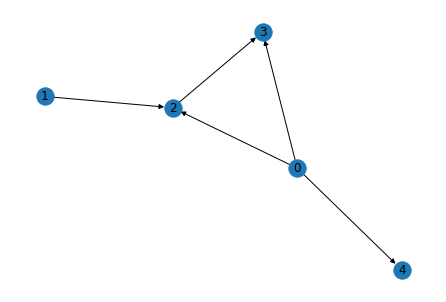

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the number of nodes and the probability of edge creation
num_nodes = 5
prob_edge_creation = 0.5

# Generate a random graph using the fast_gnp_random_graph function
random_graph = nx.dense_gnm_random_graph(num_nodes , 5)

# Draw the random graph
nx.draw(random_graph, with_labels=True, arrows=True)
plt.show()

In [9]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 2771, done.
remote: Counting objects: 100% (2771/2771), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 2771 (delta 2334), reused 2683 (delta 2246), pack-reused 0
Receiving objects: 100% (2771/2771), 10.56 MiB | 4.32 MiB/s, done.
Resolving deltas: 100% (2334/2334), done.


In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
from Eunomia.ssb import * 
from Eunomia.graph_utils import * 
from docplex.mp.model import Model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
pyro.set_rng_seed(1)

In [349]:
def remove_bidir_arcs(graph):
    graph2 = nx.DiGraph()
    for x,y in graph.edges():
        if not (y,x) in graph2.edges():
            graph2.add_edge(x,y)
    return graph2


def sample_random_graph(n, degree, method = "gnp", **kwargs):
    subsets = [tuple(i) for i in generate_additive_theta(n, degree)]
    methods = ["gnp"]
    if method not in methods:
        print("Unknown method")
        return None
    if method == "gnp":
        if not "p" in kwargs:
            print("missing param p")
            return None
        random_graph = nx.fast_gnp_random_graph(len(subsets), kwargs["p"], directed = True)
        random_graph = remove_bidir_arcs(random_graph)
        random_graph = nx.relabel_nodes(random_graph, {i: label for i, label in enumerate(subsets)})
    return random_graph

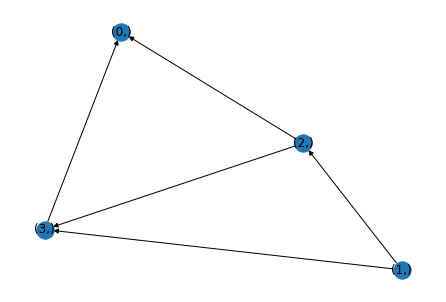

In [350]:
graph = sample_random_graph(4,1,p=0.6)
nx.draw(graph, with_labels=True, arrows=True)
plt.show()

In [351]:
def get_all_pairs(L):
    pairs = []
    for i in range(len(L)):
        for j in range(i+1, len(L)):
            pairs.append((L[i], L[j]))
    return pairs

In [509]:
class SSB_Model:
    def __init__(self, items, theta = None, phi=None, degree = 1):
        self.items = items
        if not theta and not phi:
            theta = [tuple(i) for i in generate_additive_theta(len(items), degree)]
            phi = get_all_pairs(theta)
        self.theta = theta
        self.phi = phi
        self.solved = False
        
        self.r_theta = 0
        self.r_phi = 0
        self.eps = []
        
        self.mdl = Model(name='SSB_Model')

        self.w_vars = {}
        for k in self.theta:
            self.w_vars[k] = self.mdl.continuous_var(name="w_"+str(set(k)),lb =-np.infty, ub = np.infty)
            self.r_theta =  self.r_theta + self.mdl.abs(self.w_vars[k])
             
        self.b_vars = {}      
        for k in self.phi:
            self.b_vars[k] = self.mdl.continuous_var(name="b_("+str(set(k[0]))+"->"+str(set(k[1]))+")",lb =-np.infty,ub = np.infty)
            self.r_phi =  self.r_phi + self.mdl.abs(self.b_vars[k])

    
    def project(self, x, y):
        s = 0
        for k in self.theta:
            if all(i in x for i in k):
                s += self.w_vars[k]
            if all(i in y for i in k):
                s -= self.w_vars[k]
                
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                s += self.b_vars[(A,B)]
            if all(i in x for i in B) and all(i in y for i in A):
                s -= self.b_vars[(A,B)]
        return s
    
    def fit(self, prf):
        self.prf = prf
        edges = []
        self.eps = []
        for x,y in self.prf:
            if (set(y),set(x)) in edges:
                continue
            edges.append((set(x),set(y)))
            eps = self.mdl.continuous_var(name=f"eps_({set(x)}_{set(y)})",lb =0,ub = np.infty)
            cst = self.mdl.add_constraint(self.project(x,y) >= 1 - eps, ctname = f"c_({set(x)}_{set(y)})")
            self.eps.append(eps)
        self.mdl.minimize_static_lex([self.mdl.sum(self.eps), self.r_theta + 100*self.r_phi])
        s = self.mdl.solve(log_output = False)
        if s:
            self.solved = True
        return s
    
    def predict(self, x,y):
        if not self.solved:
            print("PL not solved")
            return None
        s = 0
        for k in self.theta:
            if all(i in x for i in k):
                s += self.w_vars[k].solution_value
            if all(i in y for i in k):
                s -= self.w_vars[k].solution_value
                
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                s += self.b_vars[(A,B)].solution_value
            if all(i in x for i in B) and all(i in y for i in A):
                s -= self.b_vars[(A,B)].solution_value
        return s
    
    def n_ssb_vars(self):
        return sum([1 if np.abs(self.b_vars[i].solution_value) > 0 else 0 for i in self.b_vars])

    def n_w_vars(self):
        return sum([1 if np.abs(self.w_vars[i].solution_value) > 0 else 0 for i in self.w_vars])
    
    def ratio_of_representation(self):
        return 1 - sum([1 if i.solution_value > 0 else 0 for i in self.eps]) / len(self.eps)
    
    def print_model(self):
        print("% representation =", self.ratio_of_representation())
        for x in self.w_vars:
            if (self.w_vars[x].solution_value != 0):
                print(f"w_{x}: {self.w_vars[x].solution_value}")
        
        for x,y in self.b_vars:
            if self.b_vars[(x,y)].solution_value != 0:
                print(f"b_({x}->{y}): {self.b_vars[(x,y)].solution_value}")
            

In [510]:
n = 4
items = np.arange(n)

In [511]:
graph = sample_random_graph(n, 3, p=0.3)
prf = list(graph.edges())

In [512]:
model = SSB_Model(items, degree =1)
model.fit(prf)

docplex.mp.solution.SolveSolution(obj=32,values={w_{0}:1,_abs1:1,x3:1,w_..

In [513]:
model.print_model()

% representation = 0.5714285714285714
w_(0,): 1.0000000000000002
w_(1,): -1.0
w_(2,): -1.0000000000000002
w_(3,): -2.0
b_((0,)->(1,)): -0.9999999999999998
b_((0,)->(2,)): -2.0000000000000004
b_((2,)->(3,)): -1.0


In [515]:
model.n_w_vars()

4

In [533]:
from tqdm.notebook import tqdm

In [539]:
data = {
    "p":[],
    "n":[],
    "d_g":[],
    "d_m":[],
    "%r":[],
    "n_v_w":[],
    "n_v_b":[]
}

for p in np.linspace(0.3, 1, 5):
    for n in range(3,6):
        for d_g in range(1,n):
            for d_m in range(1,d_g+1):
                for iteration in range(100):
                    print(".", end = "")
                    if iteration % 10 == 0:
                        print("|", end = "")
                    items = np.arange(n)
                    graph = sample_random_graph(n, d_g, p=p)
                    model = SSB_Model(items,degree=d_m)
                    prf = list(graph.edges())
                    if len(prf) == 0:
                        continue
                    model.fit(prf)
                    data["p"].append(p)
                    data["n"].append(n)
                    data["d_g"].append(d_g)
                    data["d_m"].append(d_m)
                    data["%r"].append(model.ratio_of_representation())
                    data["n_v_w"].append(model.n_w_vars())
                    data["n_v_b"].append(model.n_ssb_vars())
        df = pd.DataFrame(data)
        df.to_csv("test_2.csv")
        print("\n ===========")
        print(df.groupby(["d_g","d_m"]).mean().reset_index()[["d_g", "d_m", "%r"]])
        print("===========")

.|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.........
   d_g  d_m        %r
0    1    1  1.000000
1    2    1  0.880189
2    2    2  1.000000
.|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.......